# Exercise 2: Linear and non-linear parameters

*This is the companion notebook to Exercise 2 in Hogg, Price-Whelan & Leistedt (2020).*

In [1]:
# Standard library packages
import os
import sys

# Third-party packages
import astropy.table as at
import corner
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

# Set up a deterministic random number generator:
#  Note: this requires numpy>=1.17
rnd = np.random.Generator(np.random.PCG64(seed=8675309))

In [2]:
true_pars = (3.21, 2.44, 13.6, 1.27)
K = len(true_pars)

In [3]:
def model(x, alpha, beta, gamma, omega):
    return (alpha * np.cos(omega * x) + 
            beta * np.sin(omega * x) + 
            gamma)

In [4]:
N = 4

t = at.Table()
t['x'] = np.round(np.sort(rnd.uniform(-5, 5, size=N)), 
                  decimals=1)
sigma_y = np.round(np.sort(rnd.uniform(0.1, 0.5, size=N)), 
                   decimals=1)
t['y'] = np.round(rnd.normal(model(t['x'], *true_pars),
                             sigma_y),
                  decimals=1)
t['sigma_y'] = sigma_y

t.write('data2.csv', overwrite=True)
t.write(sys.stdout, format='ascii.latex')

\begin{table}
\begin{tabular}{ccc}
x & y & sigma_y \\
-1.2 & 11.2 & 0.2 \\
1.3 & 16.1 & 0.2 \\
3.1 & 10.2 & 0.3 \\
4.1 & 13.5 & 0.3 \\
\end{tabular}
\end{table}


In [5]:
C = np.diag(t['sigma_y']**2)

In [6]:
def design_matrix(x, omega):
    M = np.ones((len(x), 3))
    M[:, 0] = np.cos(omega * x)
    M[:, 1] = np.sin(omega * x)
    return M

In [7]:
mu = np.array([0, 0, 0])

sigmas = np.array([5, 5, 10])
L = np.diag(sigmas**2)

In [8]:
def log_multivariate_gaussian(x, mu, V, Vinv):
    x = np.asarray(x, dtype=float)
    mu = np.asarray(mu, dtype=float)
    V = np.asarray(V, dtype=float)
    Vinv = np.asarray(Vinv, dtype=float)

    ndim = x.shape[-1]
    x_mu = x - mu
    
    Vshape = V.shape
    V = V.reshape([-1, ndim, ndim])

    logdet = np.log(np.array([np.linalg.det(V[i])
                              for i in range(V.shape[0])]))
    logdet = logdet.reshape(Vshape[:-2])

    xVI = np.sum(x_mu.reshape(x_mu.shape + (1,)) * Vinv, -2)
    xVIx = np.sum(xVI * x_mu, -1)

    return -0.5 * ndim * np.log(2 * np.pi) - 0.5 * (logdet + xVIx)


def compute_aA_bB(y, C, M, mu, L):
    Cinv = np.linalg.inv(C)
    Linv = np.linalg.inv(L)
    
    b = M @ mu
    B = C + M @ L @ M.T

    Ainv = Linv + M.T @ Cinv @ M
    A = np.linalg.inv(Ainv)
    Binv = Cinv - Cinv @ M @ A @ M.T @ Cinv
    a = np.linalg.solve(Ainv, Linv @ mu + M.T @ Cinv @ y)
    
    loglike = log_multivariate_gaussian(y, b, B, Vinv=Binv)

    return {
        'a': a, 'A': A,
        'b': b, 'B': B,
        'ln_marg_likelihood': loglike
    }

In [9]:
def ln_marginal_likelihood(omega, x, y, C, mu, L):
    M = design_matrix(x, omega)
    res = compute_aA_bB(y, C, M, mu, L)
    return res['ln_marg_likelihood']

In [10]:
def make_full_sample(omega, x, y, C, mu, L):
    M = design_matrix(x, omega)
    res = compute_aA_bB(y, C, M, mu, L)
    linear_sample = rnd.multivariate_normal(res['a'], res['A'])
    return np.concatenate((linear_sample, [omega]))

In [29]:
n_prior_samples = 2**18
omega_lim = (1e-2, 1e2)
prior_omega_samples = np.exp(rnd.uniform(*np.log(omega_lim), 
                                         size=n_prior_samples))

In [30]:
marg_lnlikes = np.array([ln_marginal_likelihood(omega, t['x'], t['y'], C, mu, L) 
                         for omega in prior_omega_samples])

In [31]:
mask = np.exp(marg_lnlikes - marg_lnlikes.max()) > rnd.uniform(size=n_prior_samples)
mask.sum()

1513

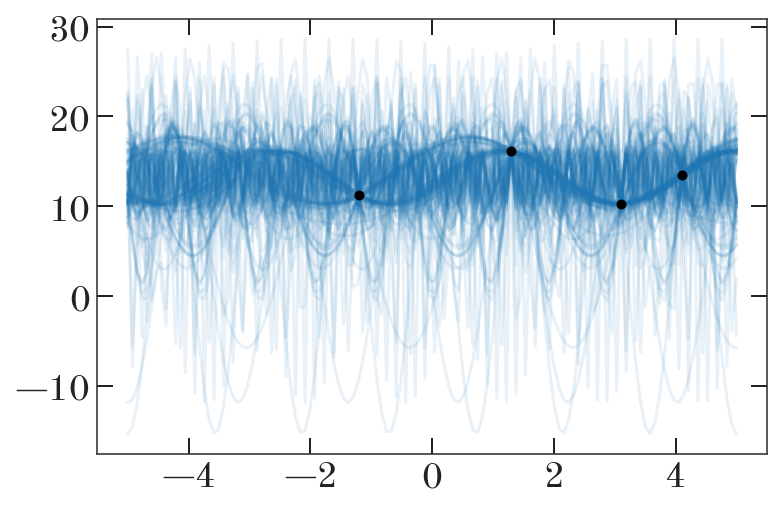

In [32]:
plt.errorbar(t['x'], t['y'], t['sigma_y'], 
             marker='o', ls='none')

grid_x = np.linspace(-5, 5, 128)
for omega in prior_omega_samples[mask][:128]:
    full_sample = make_full_sample(omega, t['x'], t['y'], C, mu, L)
    plt.plot(grid_x, model(grid_x, *full_sample),
             marker='', alpha=0.1, color='tab:blue')

In [33]:
samples = []
for omega in prior_omega_samples[mask][:1024]:
    full_sample = make_full_sample(omega, t['x'], t['y'], C, mu, L)
    samples.append(full_sample)
samples = np.array(samples)

TODO: update this

In [34]:
# plt.figure(figsize=(8, 5))

# plt.errorbar(t['x'], t['y'], t['sigma_y'], 
#              ls='none', marker='o', zorder=10,
#              label='data')

# xpred = np.linspace(-5, 5, 128)
# plt.plot(xpred, a[0] * xpred + a[1], 
#          marker='', color='tab:blue', zorder=1,
#          label='MAP model')

# ypred = samples[:, 0][None] * xpred[:, None] + samples[:, 1][None]
# yfill = np.percentile(ypred, q=[16, 84], axis=1)
# plt.fill_between(xpred, yfill[0], yfill[1], 
#                  zorder=0, color='tab:blue', alpha=0.3, lw=0,
#                  label='68% credible region')

# plt.xlim(-5, 5)
# plt.ylim(-20, 20)

# plt.xlabel('$x$')
# plt.ylabel('$y$')
# plt.legend(loc='lower right', fontsize=14)

# plt.tight_layout()
# plt.savefig('../products/exercise1.pdf')

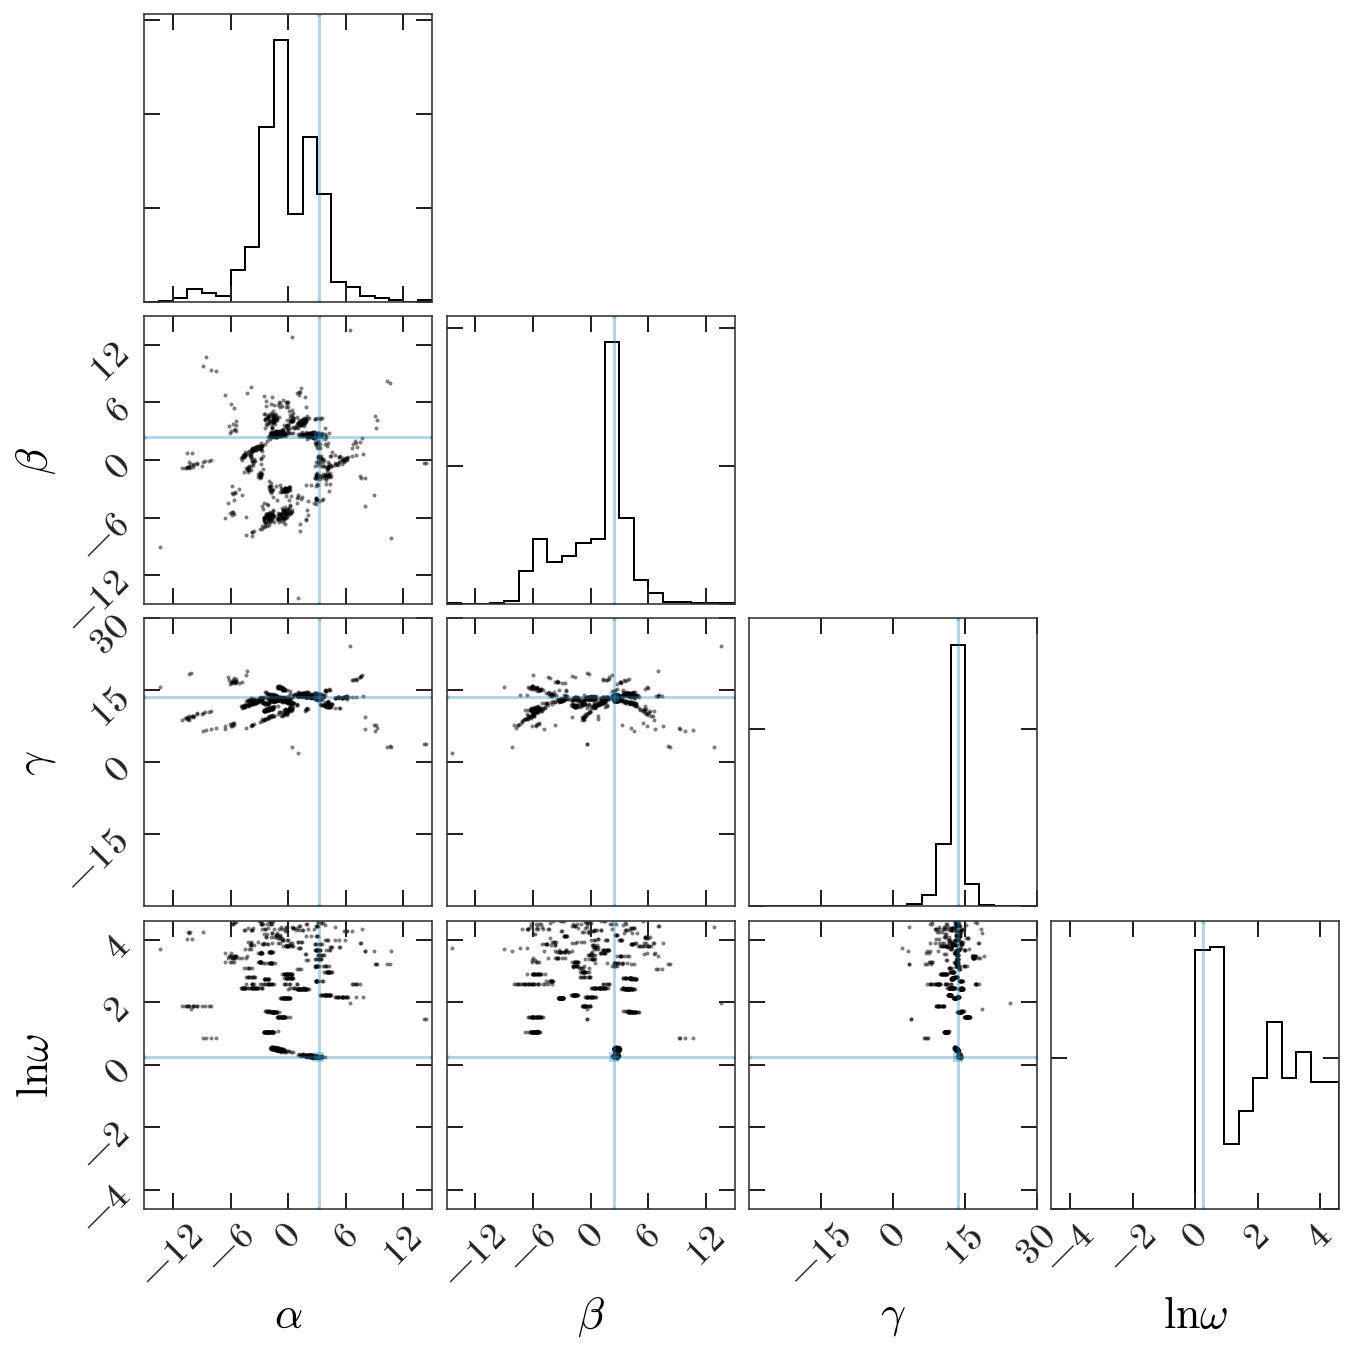

In [43]:
tmp = samples.copy()
tmp[:, 3] = np.log(tmp[:, 3])

lims = [(mu[i] - 3*np.sqrt(L[i,i]),
         mu[i] + 3*np.sqrt(L[i,i])) for i in range(K-1)] + [np.log(omega_lim)]

tmp_pars = np.array(true_pars, copy=True)
tmp_pars[3] = np.log(tmp_pars[3])

fig = corner.corner(tmp, 
                    truths=tmp_pars, 
                    range=lims,
                    plot_contours=False,
                    plot_density=False,
                    data_kwargs=dict(alpha=0.5),
                    truth_color=(0.17, 0.55, 0.75, 0.35),
                    labels=[r'$\alpha$', r'$\beta$', r'$\gamma$', r'$\ln\omega$'])
fig.set_facecolor('w')